# K-Nearest Neighbors

## Dependency

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from math import sqrt
from collections import Counter
from typing import List

## Parameter

In [101]:
data_01 = '../data/iris.data'
COLUMNS = [
    'sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class'
]
K_CV = 5
RANDOM_STATE = 0

## Function

In [102]:
def euclidean_distance(row1: List[float], row2: List[float]) -> float:
    ans = 0
    for i in range(len(row1)):
        ans += (row1[i] - row2[i])**2
    ans = sqrt(ans)
    return ans


def get_neighbors(train: List[List[float]], test: List[float], k: int) -> List[List[float]]:
    distances = []
    for t in train:
        distance = euclidean_distance(test, t)
        distances.append([distance, t])
    
    # Sort list of list of distance and train data by distance in ascending order
    distances.sort()
    
    neighbors = []
    for i in range(k):
        neighbors.append(distances[i][1])
    
    return neighbors


def classify_by_knn(train: List[List[float]], test: List[float], k):
    neighbors = get_neighbors(train, test, k)
    # row is a list of firstly list of features and at the end response
    classes = [row[-1] for row in neighbors]
    count = Counter(classes)
    # most_common returns a list of tuples (key, count)
    return count.most_common()[0][0]

## Read Iris flower species data

In [103]:
df = pd.read_csv(data_01, names=COLUMNS)

In [104]:
print(df.shape)
print(df.dtypes)

(150, 5)
sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
class            object
dtype: object


In [105]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [106]:
df.tail()

,sepal_length,sepal_width,petal_length,petal_width,class
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


In [107]:
counter = Counter(df['class'])
print(counter)

Counter({'Iris-setosa': 50, 'Iris-versicolor': 50, 'Iris-virginica': 50})


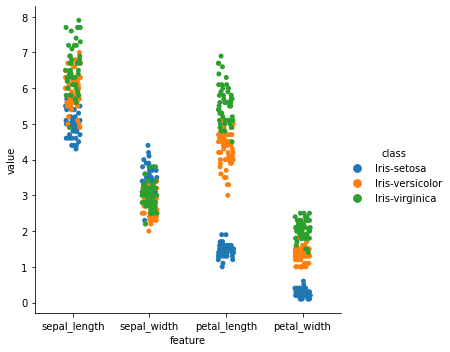

In [108]:
df_stack = df.set_index('class')
df_stack = df_stack.stack().reset_index()
df_stack = df_stack.rename(columns={
    'level_1': 'feature', 
    0: 'value'
})

sns.catplot(
    x='feature',
    y='value',
    hue='class',
    data=df_stack
)
plt.show()

## Preprocess data

In [109]:
le = LabelEncoder()
le.fit(df['class'])
classes = le.classes_
encoded = le.transform(classes)
class_to_encoded = {}
for c, e in zip(classes, encoded):
    class_to_encoded[c] = e
print(f'Label encoding: {class_to_encoded}')

Label encoding: {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}


In [110]:
df_model = df.copy()
df_model['target'] = le.transform(df['class'])
df_model = df_model.drop(columns=['class'])
df_model = shuffle(df_model, random_state=RANDOM_STATE)

In [111]:
df_model.head()

,sepal_length,sepal_width,petal_length,petal_width,target
114,5.8,2.8,5.1,2.4,2
62,6.0,2.2,4.0,1.0,1
33,5.5,4.2,1.4,0.2,0
107,7.3,2.9,6.3,1.8,2
7,5.0,3.4,1.5,0.2,0


In [112]:
df_model.tail()

,sepal_length,sepal_width,petal_length,petal_width,target
9,4.9,3.1,1.5,0.1,0
103,6.3,2.9,5.6,1.8,2
67,5.8,2.7,4.1,1.0,1
117,7.7,3.8,6.7,2.2,2
47,4.6,3.2,1.4,0.2,0


In [113]:
df_tmp = df_model.copy()
y = df_tmp.pop('target')
X = df_tmp

## KNN K-fold cross validation by scikit-learn

In [119]:
model = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [i for i in range(1, 21)]
}

gs_cv = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    scoring='accuracy',
    cv=K_CV)

gs_cv.fit(X, y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20]},
             scoring='accuracy')

In [120]:
gs_cv.best_params_

{'n_neighbors': 11}

In [121]:
gs_cv.best_score_

0.9800000000000001

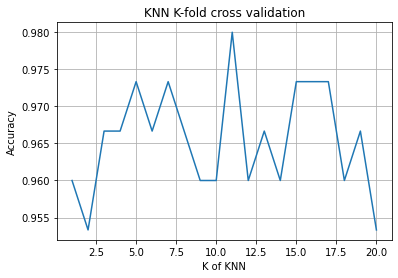

In [122]:
mean_test_score = gs_cv.cv_results_['mean_test_score']

plt.plot(
    [i for i in range(1, 21)],
    mean_test_score
)
plt.title('KNN K-fold cross validation')
plt.xlabel('K of KNN')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

## Hard-code KNN

In [138]:
kf = KFold(n_splits=K_CV, shuffle=True, random_state=RANDOM_STATE)

X_np = X.to_numpy()
y_np = y.to_numpy()

for train_index, test_index in kf.split(X):
    # print(f'Train: {train_index}, test: {test_index}')
    X_train, X_test = X_np[train_index], X_np[test_index]
    y_train, y_test = y_np[train_index], y_np[test_index]
    
    